In [ ]:
import requests
import pandas as pd
from io import StringIO
import datetime
import os
import talib
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

all_df = []
# 上市股票df
url = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y"
response = requests.get(url)
listed = pd.read_html(response.text)[0]
listed.columns = listed.iloc[0,:]
listed = listed[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
listed = listed.iloc[1:]
# 上櫃股票df
urlTWO = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=2&issuetype=&industry_code=&Page=1&chklike=Y"
response = requests.get(urlTWO)
listedTWO = pd.read_html(response.text)[0]
listedTWO.columns = listedTWO.iloc[0,:]
listedTWO = listedTWO.loc[listedTWO['有價證券別'] == '股票']
listedTWO = listedTWO[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
# 上市股票代號+.TW
stock_1 = listed["有價證券代號"]
stock_num = stock_1.apply(lambda x: str(x) + ".TW")
stock_num.loc[len(stock_num)+1] = '0050.TW'
stock_num.loc[len(stock_num)+1] = '^TWII'
# print(stock_num)
# 上櫃股票代號+.TWO
stock_2 = listedTWO["有價證券代號"]
stock_num2 = stock_2.apply(lambda x: str(x) + ".TWO")
# print(stock_num2)
# concate全部股票代號
stock_num = pd.concat([stock_num, stock_num2], ignore_index=True)
# print(stock_num)
allstock_info = pd.concat([listed, listedTWO], ignore_index=True)
allstock_info.columns = ["ID","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]
allstock_info.set_index('ID', inplace = True)
print(allstock_info)
# print(type(allstock_info['ID'].values[0]))
taiwan0050 = pd.read_csv('C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/0050.TW.csv',
                        index_col='Date', parse_dates=['Date'])
for number, d in enumerate(np.arange(-1962, -365, 93)):
    # 改日期
    while(1):
        day = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d))) , '%Y-%m-%d' )
        try:
            t = taiwan0050.loc[day]
            print('day', day)
            break
        except:
            d+=1
    ## 把要看日期的個股資料合併(一天)
    allstock = []
    for i, id in enumerate(stock_num):
        
        try:
            address = 'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/' + id + '.csv'
            stockdata = pd.DataFrame(pd.read_csv(address, index_col='Date', parse_dates=['Date']).loc[day]).transpose()
            if i == 0:
                allstock = stockdata
                # print(allstock)
            else:
                allstock = pd.concat([stockdata, allstock], ignore_index=True)
            # print(id)
        except Exception as e:
            pass
    allstock.set_index('ID', inplace = True)
    ## 建立選股條件
    #(list(map(lambda x,y , all([x,y], allstock.loc[id, 'RS EMA250rate']>85, allstock.loc[id, 'RS EMA50rate']>70))))
    for id in allstock.index.values:
        try:
            allstock.loc[id, 'Price>150MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '150MA'])
            allstock.loc[id, 'Price>200MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '200MA'])
            allstock.loc[id, '50MA>150MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '150MA'])
            allstock.loc[id, '50MA>200MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, '150MA>200MA'] = (allstock.loc[id, '150MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, 'year high sort'] = (abs((allstock.loc[id, '250Max']-allstock.loc[id, 'Adj Close'])/allstock.loc[id, '250Max'])<0.25)
            allstock.loc[id, 'year low sort'] = ((allstock.loc[id, 'Adj Close']-allstock.loc[id, '250Min'])/allstock.loc[id, '250Min']>0.25)
            allstock.loc[id, '200MA trending up 60d'] = (allstock.loc[id, '200MA ROCP 60MA'] >0)
            allstock.loc[id, '200MA trending up 20d'] = (allstock.loc[id, '200MA ROCP 20MA'] >0)
            allstock.loc[id, 'RS 250rate>80'] = (allstock.loc[id, 'RS 250rate'] > 80)
            allstock.loc[id, 'RS 50rate>80'] = (allstock.loc[id, 'RS 50rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>80'] = (allstock.loc[id, 'RS EMA250rate']>80)
            allstock.loc[id, 'RS EMA20rate>70'] = (allstock.loc[id, 'RS EMA20rate'] > 70)
            allstock.loc[id, 'RS EMA250rate>80 and EMA20rate>70'] = all(allstock.loc[id, ['RS EMA250rate>80','RS EMA20rate>70']])
            allstock.loc[id, 'RS 20rate>70'] = (allstock.loc[id, 'RS 20rate'] > 70)
            allstock.loc[id, 'RS 250rate>70'] = (allstock.loc[id, 'RS 250rate'] > 70)
            allstock.loc[id, 'Volume 50MA>100k'] = (allstock.loc[id, 'Volume 50MA'] > 100*1000)
            allstock.loc[id, 'Mark Tamplate'] = all(allstock.loc[id, ['Price>150MA', 'Price>200MA', 'year high sort', 'year low sort', '200MA trending up 60d', 'RS 250rate>80', 'Volume 50MA>100k']])
        except Exception as e:
            print(e)
            print(id, '失敗')
    ## 第一個日期選出符合條件的股票並匯出excel
    # print(allstock['Mark Tamplate'])
    allstock.dropna(subset='Mark Tamplate', inplace=True)
    apexstock = allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>70'], ['產業別', 'RS 250rate', 'RS 50rate', 'RS 20rate', 'Price>150MA', 'Price>200MA', '50MA>150MA', '50MA>200MA', '150MA>200MA',
                                                        'year high sort', 'year low sort', '200MA trending up 20d', '200MA trending up 60d', 'RS 250rate>70', 'RS 250rate>80', 'Volume 50MA>100k']]
    apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']] = apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']].astype(float).round(1)
    apexstock = apexstock.dropna()
    print(len(allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>70']].index))
    print(str(day))
    # apexstock.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/' + str(day).split(' ')[0] + 'RS選股(EMA)' + '.xlsx', encoding='utf-8-sig')


    IDs = apexstock.index.values
    day2 = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d+365))) , '%Y-%m-%d' )
    for i, ID in enumerate(IDs):
        try:
            stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TW.csv', parse_dates=['Date'], index_col=['Date'])
        except:
            try:
                stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TWO.csv', parse_dates=['Date'], index_col=['Date'])
            except Exception as e:
                print(ID)
                print(e)
        if i == 0:
            rocp_df = stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP']
            # rocp_df = rocp_df.loc[(rocp_df.index<day2)]
        else:
            rocp = pd.Series(stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP'], name = str(ID))
            rocp_df = pd.concat([rocp, rocp_df], axis=1)

    roc_df = rocp_df/100
    roc_df = roc_df+1   
    season1_profit = abs(roc_df.iloc[:63]).prod()
    season2_profit = abs(roc_df.iloc[63:126]).prod()
    season3_profit = abs(roc_df.iloc[126:189]).prod()
    season4_profit = abs(roc_df.iloc[189:]).prod()
    all_profit = abs(roc_df.iloc[:]).prod()
    season1_profit = season1_profit-1
    season2_profit = season2_profit-1
    season3_profit = season3_profit-1
    season4_profit = season4_profit-1
    all_profit = all_profit-1
    season1_profit = season1_profit.sum()
    season2_profit = season2_profit.sum()
    season3_profit = season3_profit.sum()
    season4_profit = season4_profit.sum()
    all_profit = all_profit.sum()
    profit = {'season1_profit':season1_profit,
            'season2_profit':season2_profit,
            'season3_profit':season3_profit,
            'season4_profit':season4_profit,
            'all_profit':all_profit,
            'number of stock':len(allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>70']].index)}
    if number == 0:
        all_df = pd.DataFrame(profit, index = [day])
    else:
        profit_df = pd.DataFrame(profit, index = [day])
        all_df = pd.concat([profit_df, all_df])
    display(all_df)
    # print(season1_profit.sum())
    # print(season2_profit.sum())
    # print(season3_profit.sum())
    # print(season4_profit.sum())
    # print(all_profit.sum())

In [3]:
avg_profit_df = pd.DataFrame([], columns=all_df.columns)
for ind in all_df.index.values:
    avg_profit_df.loc[ind] = 100*all_df.loc[ind]/all_df.loc[ind, 'number of stock']
avg_profit_df.loc['total'] = avg_profit_df.sum()
display(avg_profit_df)

,season1_profit,season2_profit,season3_profit,season4_profit,all_profit,number of stock
2022-07-18 00:00:00,-4.937710,8.674498,23.009848,9.969916,42.083427,100.0
2022-04-15 00:00:00,-13.961173,-1.578309,9.501563,14.843966,8.086951,100.0
2022-01-12 00:00:00,-5.241028,-4.257986,-9.667224,9.347700,-11.350269,100.0
2021-10-12 00:00:00,8.353196,-0.265247,-8.263739,-6.371809,-7.484963,100.0
2021-07-12 00:00:00,-14.807712,14.925529,-3.850674,-19.201826,-24.362858,100.0
2021-04-08 00:00:00,10.477092,-8.622226,16.399732,-6.892792,3.280447,100.0
2021-01-05 00:00:00,27.905551,12.900825,-13.498897,16.572158,41.072596,100.0
2020-10-05 00:00:00,15.600597,23.873692,8.001529,-11.293764,37.799501,100.0
2020-07-03 00:00:00,2.575060,9.928438,14.918095,0.829723,32.743633,100.0
2020-04-01 00:00:00,39.353107,2.289792,7.966910,12.410680,74.614315,100.0


In [ ]:
import requests
import pandas as pd
from io import StringIO
import datetime
import os
import talib
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

all_df = []
# 上市股票df
url = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y"
response = requests.get(url)
listed = pd.read_html(response.text)[0]
listed.columns = listed.iloc[0,:]
listed = listed[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
listed = listed.iloc[1:]
# 上櫃股票df
urlTWO = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=2&issuetype=&industry_code=&Page=1&chklike=Y"
response = requests.get(urlTWO)
listedTWO = pd.read_html(response.text)[0]
listedTWO.columns = listedTWO.iloc[0,:]
listedTWO = listedTWO.loc[listedTWO['有價證券別'] == '股票']
listedTWO = listedTWO[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
# 上市股票代號+.TW
stock_1 = listed["有價證券代號"]
stock_num = stock_1.apply(lambda x: str(x) + ".TW")
stock_num.loc[len(stock_num)+1] = '0050.TW'
stock_num.loc[len(stock_num)+1] = '^TWII'
# print(stock_num)
# 上櫃股票代號+.TWO
stock_2 = listedTWO["有價證券代號"]
stock_num2 = stock_2.apply(lambda x: str(x) + ".TWO")
# print(stock_num2)
# concate全部股票代號
stock_num = pd.concat([stock_num, stock_num2], ignore_index=True)
# print(stock_num)
allstock_info = pd.concat([listed, listedTWO], ignore_index=True)
allstock_info.columns = ["ID","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]
allstock_info.set_index('ID', inplace = True)
print(allstock_info)
# print(type(allstock_info['ID'].values[0]))
taiwan0050 = pd.read_csv('C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/0050.TW.csv',
                        index_col='Date', parse_dates=['Date'])
for number, d in enumerate(np.arange(-1962, -365, 93)):
    # 改日期
    while(1):
        day = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d))) , '%Y-%m-%d' )
        try:
            t = taiwan0050.loc[day]
            print('day', day)
            break
        except:
            d+=1
    ## 把要看日期的個股資料合併(一天)
    allstock = []
    for i, id in enumerate(stock_num):
        
        try:
            address = 'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/' + id + '.csv'
            stockdata = pd.DataFrame(pd.read_csv(address, index_col='Date', parse_dates=['Date']).loc[day]).transpose()
            if i == 0:
                allstock = stockdata
                # print(allstock)
            else:
                allstock = pd.concat([stockdata, allstock], ignore_index=True)
            # print(id)
        except Exception as e:
            pass
    allstock.set_index('ID', inplace = True)
    ## 建立選股條件
    #(list(map(lambda x,y , all([x,y], allstock.loc[id, 'RS EMA250rate']>85, allstock.loc[id, 'RS EMA50rate']>70))))
    for id in allstock.index.values:
        try:
            allstock.loc[id, 'Price>150MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '150MA'])
            allstock.loc[id, 'Price>200MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '200MA'])
            allstock.loc[id, '50MA>150MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '150MA'])
            allstock.loc[id, '50MA>200MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, '150MA>200MA'] = (allstock.loc[id, '150MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, 'year high sort'] = (abs((allstock.loc[id, '250Max']-allstock.loc[id, 'Adj Close'])/allstock.loc[id, '250Max'])<0.25)
            allstock.loc[id, 'year low sort'] = ((allstock.loc[id, 'Adj Close']-allstock.loc[id, '250Min'])/allstock.loc[id, '250Min']>0.25)
            allstock.loc[id, '200MA trending up 60d'] = (allstock.loc[id, '200MA ROCP 60MA'] >0)
            allstock.loc[id, '200MA trending up 20d'] = (allstock.loc[id, '200MA ROCP 20MA'] >0)
            allstock.loc[id, 'RS 250rate>80'] = (allstock.loc[id, 'RS 250rate'] > 80)
            allstock.loc[id, 'RS 50rate>80'] = (allstock.loc[id, 'RS 50rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>80'] = (allstock.loc[id, 'RS EMA250rate']>80)
            allstock.loc[id, 'RS EMA20rate>70'] = (allstock.loc[id, 'RS EMA20rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>80 and EMA20rate>80'] = all(allstock.loc[id, ['RS EMA250rate>80','RS EMA20rate>70']])
            allstock.loc[id, 'RS 20rate>70'] = (allstock.loc[id, 'RS 20rate'] > 70)
            allstock.loc[id, 'RS 250rate>70'] = (allstock.loc[id, 'RS 250rate'] > 70)
            allstock.loc[id, 'Volume 50MA>100k'] = (allstock.loc[id, 'Volume 50MA'] > 100*1000)
            allstock.loc[id, 'Mark Tamplate'] = all(allstock.loc[id, ['Price>150MA', 'Price>200MA', 'year high sort', 'year low sort', '200MA trending up 60d', 'RS 250rate>80', 'Volume 50MA>100k']])
        except Exception as e:
            print(e)
            print(id, '失敗')
    ## 第一個日期選出符合條件的股票並匯出excel
    # print(allstock['Mark Tamplate'])
    allstock.dropna(subset='Mark Tamplate', inplace=True)
    apexstock = allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80'], ['產業別', 'RS 250rate', 'RS 50rate', 'RS 20rate', 'Price>150MA', 'Price>200MA', '50MA>150MA', '50MA>200MA', '150MA>200MA',
                                                        'year high sort', 'year low sort', '200MA trending up 20d', '200MA trending up 60d', 'RS 250rate>70', 'RS 250rate>80', 'Volume 50MA>100k']]
    apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']] = apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']].astype(float).round(1)
    apexstock = apexstock.dropna()
    print(len(allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80']].index))
    print(str(day))
    # apexstock.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/' + str(day).split(' ')[0] + 'RS選股(EMA)' + '.xlsx', encoding='utf-8-sig')


    IDs = apexstock.index.values
    day2 = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d+365))) , '%Y-%m-%d' )
    for i, ID in enumerate(IDs):
        try:
            stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TW.csv', parse_dates=['Date'], index_col=['Date'])
        except:
            try:
                stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TWO.csv', parse_dates=['Date'], index_col=['Date'])
            except Exception as e:
                print(ID)
                print(e)
        if i == 0:
            rocp_df = stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP']
            # rocp_df = rocp_df.loc[(rocp_df.index<day2)]
        else:
            rocp = pd.Series(stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP'], name = str(ID))
            rocp_df = pd.concat([rocp, rocp_df], axis=1)

    roc_df = rocp_df/100
    roc_df = roc_df+1   
    season1_profit = abs(roc_df.iloc[:63]).prod()
    season2_profit = abs(roc_df.iloc[63:126]).prod()
    season3_profit = abs(roc_df.iloc[126:189]).prod()
    season4_profit = abs(roc_df.iloc[189:]).prod()
    all_profit = abs(roc_df.iloc[:]).prod()
    season1_profit = season1_profit-1
    season2_profit = season2_profit-1
    season3_profit = season3_profit-1
    season4_profit = season4_profit-1
    all_profit = all_profit-1
    season1_profit = season1_profit.sum()
    season2_profit = season2_profit.sum()
    season3_profit = season3_profit.sum()
    season4_profit = season4_profit.sum()
    all_profit = all_profit.sum()
    profit = {'season1_profit':season1_profit,
            'season2_profit':season2_profit,
            'season3_profit':season3_profit,
            'season4_profit':season4_profit,
            'all_profit':all_profit,
            'number of stock':len(allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80']].index)}
    if number == 0:
        all_df = pd.DataFrame(profit, index = [day])
    else:
        profit_df = pd.DataFrame(profit, index = [day])
        all_df = pd.concat([profit_df, all_df])
    display(all_df)
    # print(season1_profit.sum())
    # print(season2_profit.sum())
    # print(season3_profit.sum())
    # print(season4_profit.sum())
    # print(all_profit.sum())

In [5]:
avg_profit_df2 = pd.DataFrame([], columns=all_df.columns)
for ind in all_df.index.values:
    avg_profit_df2.loc[ind] = 100*all_df.loc[ind]/all_df.loc[ind, 'number of stock']
avg_profit_df2.loc['total'] = avg_profit_df2.sum()
display(avg_profit_df2)

,season1_profit,season2_profit,season3_profit,season4_profit,all_profit,number of stock
2022-07-18 00:00:00,-5.623118,7.696488,22.290143,10.933356,40.414336,100.0
2022-04-15 00:00:00,-14.319994,-1.365744,9.384129,15.526155,8.491465,100.0
2022-01-12 00:00:00,-4.620774,-3.816504,-9.118492,8.866589,-10.318402,100.0
2021-10-12 00:00:00,7.652305,-1.848200,-8.201948,-6.087912,-9.752104,100.0
2021-07-12 00:00:00,-16.062500,15.011137,-5.052257,-19.409718,-27.045049,100.0
2021-04-08 00:00:00,12.198581,-8.603476,16.293053,-6.250577,4.986427,100.0
2021-01-05 00:00:00,28.705853,14.722139,-14.745382,17.184297,41.864211,100.0
2020-10-05 00:00:00,15.074011,20.192320,8.594376,-11.248751,34.953832,100.0
2020-07-03 00:00:00,2.647573,9.698173,14.589144,0.956654,33.417338,100.0
2020-04-01 00:00:00,39.324317,1.534330,8.533344,12.512428,74.263381,100.0


In [ ]:
import requests
import pandas as pd
from io import StringIO
import datetime
import os
import talib
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

all_df = []
# 上市股票df
url = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y"
response = requests.get(url)
listed = pd.read_html(response.text)[0]
listed.columns = listed.iloc[0,:]
listed = listed[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
listed = listed.iloc[1:]
# 上櫃股票df
urlTWO = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=2&issuetype=&industry_code=&Page=1&chklike=Y"
response = requests.get(urlTWO)
listedTWO = pd.read_html(response.text)[0]
listedTWO.columns = listedTWO.iloc[0,:]
listedTWO = listedTWO.loc[listedTWO['有價證券別'] == '股票']
listedTWO = listedTWO[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
# 上市股票代號+.TW
stock_1 = listed["有價證券代號"]
stock_num = stock_1.apply(lambda x: str(x) + ".TW")
stock_num.loc[len(stock_num)+1] = '0050.TW'
stock_num.loc[len(stock_num)+1] = '^TWII'
# print(stock_num)
# 上櫃股票代號+.TWO
stock_2 = listedTWO["有價證券代號"]
stock_num2 = stock_2.apply(lambda x: str(x) + ".TWO")
# print(stock_num2)
# concate全部股票代號
stock_num = pd.concat([stock_num, stock_num2], ignore_index=True)
# print(stock_num)
allstock_info = pd.concat([listed, listedTWO], ignore_index=True)
allstock_info.columns = ["ID","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]
allstock_info.set_index('ID', inplace = True)
print(allstock_info)
# print(type(allstock_info['ID'].values[0]))
taiwan0050 = pd.read_csv('C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/0050.TW.csv',
                        index_col='Date', parse_dates=['Date'])
for number, d in enumerate(np.arange(-1962, -365, 62)):
    # 改日期
    while(1):
        day = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d))) , '%Y-%m-%d' )
        try:
            t = taiwan0050.loc[day]
            print('day', day)
            break
        except:
            d+=1
    ## 把要看日期的個股資料合併(一天)
    allstock = []
    for i, id in enumerate(stock_num):
        
        try:
            address = 'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/' + id + '.csv'
            stockdata = pd.DataFrame(pd.read_csv(address, index_col='Date', parse_dates=['Date']).loc[day]).transpose()
            if i == 0:
                allstock = stockdata
                # print(allstock)
            else:
                allstock = pd.concat([stockdata, allstock], ignore_index=True)
            # print(id)
        except Exception as e:
            pass
    allstock.set_index('ID', inplace = True)
    ## 建立選股條件
    #(list(map(lambda x,y , all([x,y], allstock.loc[id, 'RS EMA250rate']>85, allstock.loc[id, 'RS EMA50rate']>70))))
    for id in allstock.index.values:
        try:
            allstock.loc[id, 'Price>150MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '150MA'])
            allstock.loc[id, 'Price>200MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '200MA'])
            allstock.loc[id, '50MA>150MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '150MA'])
            allstock.loc[id, '50MA>200MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, '150MA>200MA'] = (allstock.loc[id, '150MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, 'year high sort'] = (abs((allstock.loc[id, '250Max']-allstock.loc[id, 'Adj Close'])/allstock.loc[id, '250Max'])<0.25)
            allstock.loc[id, 'year low sort'] = ((allstock.loc[id, 'Adj Close']-allstock.loc[id, '250Min'])/allstock.loc[id, '250Min']>0.25)
            allstock.loc[id, '200MA trending up 60d'] = (allstock.loc[id, '200MA ROCP 60MA'] >0)
            allstock.loc[id, '200MA trending up 20d'] = (allstock.loc[id, '200MA ROCP 20MA'] >0)
            allstock.loc[id, 'RS 250rate>80'] = (allstock.loc[id, 'RS 250rate'] > 80)
            allstock.loc[id, 'RS 50rate>80'] = (allstock.loc[id, 'RS 50rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>80'] = (allstock.loc[id, 'RS EMA250rate']>80)
            allstock.loc[id, 'RS EMA20rate>70'] = (allstock.loc[id, 'RS EMA20rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>80 and EMA20rate>80'] = all(allstock.loc[id, ['RS EMA250rate>80','RS EMA20rate>70']])
            allstock.loc[id, 'RS 20rate>70'] = (allstock.loc[id, 'RS 20rate'] > 70)
            allstock.loc[id, 'RS 250rate>70'] = (allstock.loc[id, 'RS 250rate'] > 70)
            allstock.loc[id, 'Volume 50MA>100k'] = (allstock.loc[id, 'Volume 50MA'] > 100*1000)
            allstock.loc[id, 'Mark Tamplate'] = all(allstock.loc[id, ['Price>150MA', 'Price>200MA', 'year high sort', 'year low sort', '200MA trending up 60d', 'RS 250rate>80', 'Volume 50MA>100k']])
        except Exception as e:
            print(e)
            print(id, '失敗')
    ## 第一個日期選出符合條件的股票並匯出excel
    # print(allstock['Mark Tamplate'])
    allstock.dropna(subset='Mark Tamplate', inplace=True)
    apexstock = allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80'], ['產業別', 'RS 250rate', 'RS 50rate', 'RS 20rate', 'Price>150MA', 'Price>200MA', '50MA>150MA', '50MA>200MA', '150MA>200MA',
                                                        'year high sort', 'year low sort', '200MA trending up 20d', '200MA trending up 60d', 'RS 250rate>70', 'RS 250rate>80', 'Volume 50MA>100k']]
    apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']] = apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']].astype(float).round(1)
    apexstock = apexstock.dropna()
    print(len(allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80']].index))
    print(str(day))
    # apexstock.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/' + str(day).split(' ')[0] + 'RS選股(EMA)' + '.xlsx', encoding='utf-8-sig')


    IDs = apexstock.index.values
    day2 = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d+365))) , '%Y-%m-%d' )
    for i, ID in enumerate(IDs):
        try:
            stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TW.csv', parse_dates=['Date'], index_col=['Date'])
        except:
            try:
                stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TWO.csv', parse_dates=['Date'], index_col=['Date'])
            except Exception as e:
                print(ID)
                print(e)
        if i == 0:
            rocp_df = stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP']
            # rocp_df = rocp_df.loc[(rocp_df.index<day2)]
        else:
            rocp = pd.Series(stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP'], name = str(ID))
            rocp_df = pd.concat([rocp, rocp_df], axis=1)

    roc_df = rocp_df/100
    roc_df = roc_df+1   
    season1_profit = abs(roc_df.iloc[:42]).prod()
    season2_profit = abs(roc_df.iloc[42:84]).prod()
    season3_profit = abs(roc_df.iloc[84:126]).prod()
    season4_profit = abs(roc_df.iloc[126:168]).prod()
    season5_profit = abs(roc_df.iloc[168:210]).prod()
    season6_profit = abs(roc_df.iloc[210:]).prod()
    all_profit = abs(roc_df.iloc[:]).prod()
    season1_profit = season1_profit-1
    season2_profit = season2_profit-1
    season3_profit = season3_profit-1
    season4_profit = season4_profit-1
    season5_profit = season5_profit-1
    season6_profit = season6_profit-1
    all_profit = all_profit-1
    season1_profit = season1_profit.sum()
    season2_profit = season2_profit.sum()
    season3_profit = season3_profit.sum()
    season4_profit = season4_profit.sum()
    season5_profit = season5_profit.sum()
    season6_profit = season6_profit.sum()
    all_profit = all_profit.sum()
    profit = {'season1_profit':season1_profit,
            'season2_profit':season2_profit,
            'season3_profit':season3_profit,
            'season4_profit':season4_profit,
            'season5_profit':season3_profit,
            'season6_profit':season4_profit,
            'all_profit':all_profit,
            'number of stock':len(allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80']].index)}
    if number == 0:
        all_df = pd.DataFrame(profit, index = [day])
    else:
        profit_df = pd.DataFrame(profit, index = [day])
        all_df = pd.concat([profit_df, all_df])
    display(all_df)
    # print(season1_profit.sum())
    # print(season2_profit.sum())
    # print(season3_profit.sum())
    # print(season4_profit.sum())
    # print(all_profit.sum())

In [8]:
avg_profit_df3 = pd.DataFrame([], columns=all_df.columns)
for ind in all_df.index.values:
    avg_profit_df3.loc[ind] = 100*all_df.loc[ind]/all_df.loc[ind, 'number of stock']
avg_profit_df3.loc['total'] = avg_profit_df3.sum()
display(avg_profit_df3)

,season1_profit,season2_profit,season3_profit,season4_profit,season5_profit,season6_profit,all_profit,number of stock
2022-06-17 00:00:00,6.432541,-8.790536,11.828645,9.741251,11.828645,9.741251,36.585919,100.0
2022-04-18 00:00:00,-8.638123,3.935332,-8.886803,12.075100,-8.886803,12.075100,11.383392,100.0
2022-02-14 00:00:00,0.447565,-3.320135,0.555729,-12.890370,0.555729,-12.890370,-3.748968,100.0
2021-12-13 00:00:00,-3.737146,-10.531662,-3.107311,5.822020,-3.107311,5.822020,-16.102013,100.0
2021-10-12 00:00:00,9.711077,-3.212817,-0.503839,-8.970647,-0.503839,-8.970647,-9.752104,100.0
2021-08-11 00:00:00,-3.078710,12.297689,-0.262438,-1.263000,-0.262438,-1.263000,-2.880851,100.0
2021-06-10 00:00:00,11.281399,-10.511791,18.429490,-3.528118,18.429490,-3.528118,6.887448,100.0
2021-04-09 00:00:00,-3.546286,11.787791,-9.237195,16.826973,-9.237195,16.826973,5.149092,100.0
2021-02-17 00:00:00,22.130221,0.587419,-3.072223,1.495685,-3.072223,1.495685,30.914032,100.0
2020-12-07 00:00:00,3.508316,38.182386,-4.170588,2.205491,-4.170588,2.205491,62.023409,100.0


In [ ]:
import requests
import pandas as pd
from io import StringIO
import datetime
import os
import talib
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

all_df = []
# 上市股票df
url = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y"
response = requests.get(url)
listed = pd.read_html(response.text)[0]
listed.columns = listed.iloc[0,:]
listed = listed[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
listed = listed.iloc[1:]
# 上櫃股票df
urlTWO = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=2&issuetype=&industry_code=&Page=1&chklike=Y"
response = requests.get(urlTWO)
listedTWO = pd.read_html(response.text)[0]
listedTWO.columns = listedTWO.iloc[0,:]
listedTWO = listedTWO.loc[listedTWO['有價證券別'] == '股票']
listedTWO = listedTWO[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
# 上市股票代號+.TW
stock_1 = listed["有價證券代號"]
stock_num = stock_1.apply(lambda x: str(x) + ".TW")
stock_num.loc[len(stock_num)+1] = '0050.TW'
stock_num.loc[len(stock_num)+1] = '^TWII'
# print(stock_num)
# 上櫃股票代號+.TWO
stock_2 = listedTWO["有價證券代號"]
stock_num2 = stock_2.apply(lambda x: str(x) + ".TWO")
# print(stock_num2)
# concate全部股票代號
stock_num = pd.concat([stock_num, stock_num2], ignore_index=True)
# print(stock_num)
allstock_info = pd.concat([listed, listedTWO], ignore_index=True)
allstock_info.columns = ["ID","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]
allstock_info.set_index('ID', inplace = True)
print(allstock_info)
# print(type(allstock_info['ID'].values[0]))
taiwan0050 = pd.read_csv('C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/0050.TW.csv',
                        index_col='Date', parse_dates=['Date'])
for number, d in enumerate(np.arange(-5000, -30, 62)):
    # 改日期
    while(1):
        day = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d))) , '%Y-%m-%d' )
        try:
            t = taiwan0050.loc[day]
            print('day', day)
            break
        except:
            d+=1
    ## 把要看日期的個股資料合併(一天)
    allstock = []
    for i, id in enumerate(stock_num):
        
        try:
            address = 'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/' + id + '.csv'
            stockdata = pd.DataFrame(pd.read_csv(address, index_col='Date', parse_dates=['Date']).loc[day]).transpose()
            if i == 0:
                allstock = stockdata
                # print(allstock)
            else:
                allstock = pd.concat([stockdata, allstock], ignore_index=True)
            # print(id)
        except Exception as e:
            pass
    allstock.set_index('ID', inplace = True)
    ## 建立選股條件
    #(list(map(lambda x,y , all([x,y], allstock.loc[id, 'RS EMA250rate']>85, allstock.loc[id, 'RS EMA50rate']>70))))
    for id in allstock.index.values:
        try:
            allstock.loc[id, 'Price>150MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '150MA'])
            allstock.loc[id, 'Price>200MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '200MA'])
            allstock.loc[id, '50MA>150MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '150MA'])
            allstock.loc[id, '50MA>200MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, '150MA>200MA'] = (allstock.loc[id, '150MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, 'year high sort'] = (abs((allstock.loc[id, '250Max']-allstock.loc[id, 'Adj Close'])/allstock.loc[id, '250Max'])<0.25)
            allstock.loc[id, 'year low sort'] = ((allstock.loc[id, 'Adj Close']-allstock.loc[id, '250Min'])/allstock.loc[id, '250Min']>0.25)
            allstock.loc[id, '200MA trending up 60d'] = (allstock.loc[id, '200MA ROCP 60MA'] >0)
            allstock.loc[id, '200MA trending up 20d'] = (allstock.loc[id, '200MA ROCP 20MA'] >0)
            allstock.loc[id, 'RS 250rate>80'] = (allstock.loc[id, 'RS 250rate'] > 80)
            allstock.loc[id, 'RS 50rate>80'] = (allstock.loc[id, 'RS 50rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>80'] = (allstock.loc[id, 'RS EMA250rate']>80)
            allstock.loc[id, 'RS EMA20rate>70'] = (allstock.loc[id, 'RS EMA20rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>80 and EMA20rate>80'] = all(allstock.loc[id, ['RS EMA250rate>80','RS EMA20rate>70']])
            allstock.loc[id, 'RS 20rate>70'] = (allstock.loc[id, 'RS 20rate'] > 70)
            allstock.loc[id, 'RS 250rate>70'] = (allstock.loc[id, 'RS 250rate'] > 70)
            allstock.loc[id, 'Volume 50MA>100k'] = (allstock.loc[id, 'Volume 50MA'] > 100*1000)
            allstock.loc[id, 'Mark Tamplate'] = all(allstock.loc[id, ['Price>150MA', 'Price>200MA', 'year high sort', 'year low sort', '200MA trending up 60d', 'RS 250rate>80', 'Volume 50MA>100k']])
        except Exception as e:
            print(e)
            print(id, '失敗')
    ## 第一個日期選出符合條件的股票並匯出excel
    # print(allstock['Mark Tamplate'])
    allstock.dropna(subset='Mark Tamplate', inplace=True)
    apexstock = allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80'], ['產業別', 'RS 250rate', 'RS 50rate', 'RS 20rate', 'Price>150MA', 'Price>200MA', '50MA>150MA', '50MA>200MA', '150MA>200MA',
                                                        'year high sort', 'year low sort', '200MA trending up 20d', '200MA trending up 60d', 'RS 250rate>70', 'RS 250rate>80', 'Volume 50MA>100k']]
    apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']] = apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']].astype(float).round(1)
    apexstock = apexstock.dropna()
    print(len(allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80']].index))
    print(str(day))
    # apexstock.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/' + str(day).split(' ')[0] + 'RS選股(EMA)' + '.xlsx', encoding='utf-8-sig')


    IDs = apexstock.index.values
    day2 = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d+365))) , '%Y-%m-%d' )
    for i, ID in enumerate(IDs):
        try:
            stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TW.csv', parse_dates=['Date'], index_col=['Date'])
        except:
            try:
                stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TWO.csv', parse_dates=['Date'], index_col=['Date'])
            except Exception as e:
                print(ID)
                print(e)
        if i == 0:
            rocp_df = stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP']
            # rocp_df = rocp_df.loc[(rocp_df.index<day2)]
        else:
            rocp = pd.Series(stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP'], name = str(ID))
            rocp_df = pd.concat([rocp, rocp_df], axis=1)

    roc_df = rocp_df/100
    roc_df = roc_df+1   
    season1_profit = abs(roc_df.iloc[:42]).prod()
    season2_profit = abs(roc_df.iloc[42:84]).prod()
    season3_profit = abs(roc_df.iloc[84:126]).prod()
    season4_profit = abs(roc_df.iloc[126:168]).prod()
    season5_profit = abs(roc_df.iloc[168:210]).prod()
    season6_profit = abs(roc_df.iloc[210:]).prod()
    all_profit = abs(roc_df.iloc[:]).prod()
    season1_profit = season1_profit-1
    season2_profit = season2_profit-1
    season3_profit = season3_profit-1
    season4_profit = season4_profit-1
    season5_profit = season5_profit-1
    season6_profit = season6_profit-1
    all_profit = all_profit-1
    season1_profit = season1_profit.sum()
    season2_profit = season2_profit.sum()
    season3_profit = season3_profit.sum()
    season4_profit = season4_profit.sum()
    season5_profit = season5_profit.sum()
    season6_profit = season6_profit.sum()
    all_profit = all_profit.sum()
    profit = {'season1_profit':season1_profit,
            'season2_profit':season2_profit,
            'season3_profit':season3_profit,
            'season4_profit':season4_profit,
            'season5_profit':season3_profit,
            'season6_profit':season4_profit,
            'all_profit':all_profit,
            'number of stock':len(allstock.loc[allstock['RS EMA250rate>80 and EMA20rate>80']].index)}
    if number == 0:
        all_df = pd.DataFrame(profit, index = [day])
    else:
        profit_df = pd.DataFrame(profit, index = [day])
        all_df = pd.concat([profit_df, all_df])
    display(all_df)
    # print(season1_profit.sum())
    # print(season2_profit.sum())
    # print(season3_profit.sum())
    # print(season4_profit.sum())
    # print(all_profit.sum())

In [10]:
avg_profit_df4 = pd.DataFrame([], columns=all_df.columns)
for ind in all_df.index.values:
    avg_profit_df4.loc[ind] = 100*all_df.loc[ind]/all_df.loc[ind, 'number of stock']
avg_profit_df4.loc['total'] = avg_profit_df4.sum()
display(avg_profit_df4)

,season1_profit,season2_profit,season3_profit,season4_profit,season5_profit,season6_profit,all_profit,number of stock
2023-06-26 00:00:00,-2.444267,0.000000,0.000000,0.000000,0.000000,0.000000,-2.444267,100.0
2023-04-24 00:00:00,9.245890,-1.692783,0.000000,0.000000,0.000000,0.000000,7.335380,100.0
2023-02-20 00:00:00,8.542262,13.097055,-2.830351,0.000000,-2.830351,0.000000,18.343792,100.0
2022-12-20 00:00:00,15.788164,10.107770,10.574058,-4.311154,10.574058,-4.311154,36.053047,100.0
2022-10-19 00:00:00,6.270232,8.290796,8.511042,7.215530,8.511042,7.215530,27.667249,100.0
...,...,...,...,...,...,...,...,...
2010-05-31 00:00:00,4.323619,4.496595,0.029766,8.081965,0.029766,8.081965,14.173190,100.0
2010-03-29 00:00:00,-6.028795,11.811882,1.107694,-3.997374,1.107694,-3.997374,5.296028,100.0
2010-01-25 00:00:00,6.384016,329.630820,11.954204,1.284294,11.954204,1.284294,56.306728,100.0
2009-11-24 00:00:00,15.888254,6.026158,-8.591110,8.199118,-8.591110,8.199118,16.182741,100.0


In [12]:
avg_profit_df4.to_excel(r'C:\Users\User\Desktop\code\python\stockdata_VCP\VCP_predict_project\ETF test\RS EMA250rate大於80 and EMA20rate大於80.xlsx')

In [4]:
import pandas as pd
import numpy as np
avg_profit_df = pd.read_excel(r'C:\Users\User\Desktop\code\python\stockdata_VCP\VCP_predict_project\ETF test\T7.xlsx')
avg_profit_df.set_index('Unnamed: 0', inplace=True)
display(avg_profit_df)
profit_percentage = avg_profit_df.iloc[:-1, 0]/100+1
profit_percentage = profit_percentage.values[::-1]
profit_percentage

,season1_profit,number of stock
Unnamed: 0,,
2023-06-26 00:00:00,-1.631262,100
2023-04-24 00:00:00,18.098566,100
2023-02-20 00:00:00,8.609349,100
2022-12-19 00:00:00,12.466069,100
2022-10-18 00:00:00,8.932519,100
...,...,...
2010-05-28 00:00:00,5.125907,100
2010-03-29 00:00:00,-8.678513,100
2010-01-25 00:00:00,11.074321,100


array([1.13625859, 1.11074321, 0.91321487, 1.05125907, 1.01422411,
       0.99198559, 0.98145935, 0.99874305, 1.00003588, 0.91851056,
       0.83053519, 0.8972644 , 1.12554763, 0.93415244, 0.89451287,
       1.07158298, 0.99278581, 1.03135695, 1.04910024, 1.05691258,
       1.06478194, 1.02526578, 1.0841013 , 1.0042429 , 1.10707728,
       1.06701947, 1.07890638, 0.89939274, 0.88295391, 1.08128387,
       0.99603749, 1.0702503 , 1.00539545, 0.78355387, 1.11002021,
       1.00871557, 1.10286644, 0.93319005, 1.08414885, 1.02107766,
       0.94760072, 1.1307287 , 1.15443355, 0.99708504, 1.03921201,
       1.1045166 , 1.03339376, 1.0754888 , 1.00783781, 1.01652086,
       1.00669073, 0.85824822, 0.85556542, 1.05903544, 1.11919121,
       0.91255493, 1.08522193, 1.04383983, 1.0466999 , 1.05992774,
       0.81543558, 1.36922866, 1.14863344, 1.03670552, 1.02452254,
       1.000176  , 1.30442548, 0.92554769, 1.13350551, 0.95941785,
       1.12238351, 0.9624638 , 0.99950077, 0.91540756, 1.03983

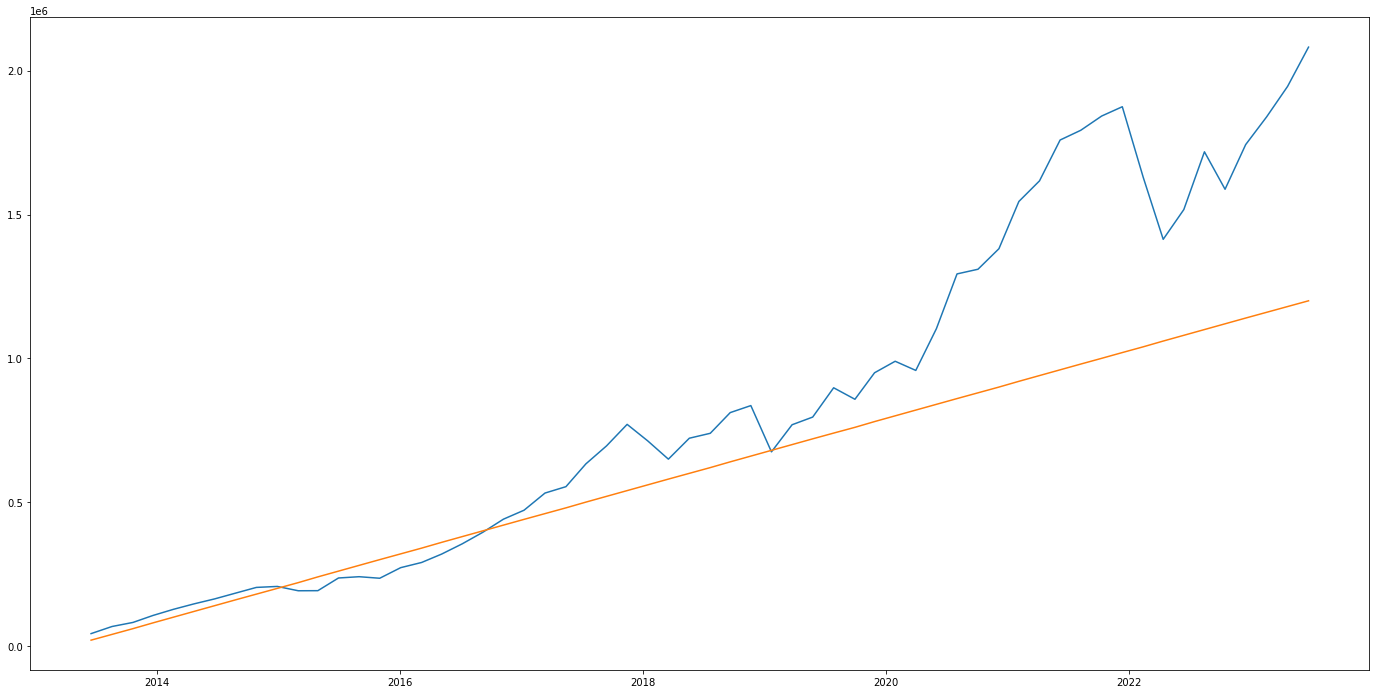

1220000
170.66151739501322


In [6]:
import matplotlib.pyplot as plt
day_index = avg_profit_df.index.values
initial_money = 20000
now_money = 20000
add_money = 20000
now_profit = 0
all_profit = 0
all_profit_list = []
all_asset = []
pay_money = [20000]
for i in range(60):
    now_profit = now_money*(profit_percentage[i]-1)
    all_profit += now_profit
    all_profit_list.append(all_profit)
    now_money = now_profit+now_money+add_money
    all_asset.append(now_money)
    pay_money.append(pay_money[-1]+add_money)
    # print(all_asset)
# plt.figure(figsize=(24,12))
# plt.plot(day_index[:60], all_profit_list[::-1] ,label='Profit')
# ax2 = plt.gca().twinx()
# ax2.plot(day_index[:60], pay_money[:-1][::-1], label='Pay', color='red')
# ax3 = plt.gca().twinx()
# ax3.plot(day_index[:60], all_asset[::-1], label='All')
# lines, labels = plt.gca().get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# lines3, labels3 = ax3.get_legend_handles_labels()
# plt.legend(lines + lines2 + lines3, labels + labels2 +labels3, loc='upper right')
# plt.ylabel('Profit')
# ax2.set_ylabel('Profit')
# ax3.set_ylabel('Profit')
# plt.show()
plt.figure(figsize=(24,12))
plt.plot(day_index[:60], all_asset[::-1])
plt.plot(day_index[:60], pay_money[:-1][::-1])
plt.show()
print(pay_money[-1])
print(all_asset[-1]*100/pay_money[-1])

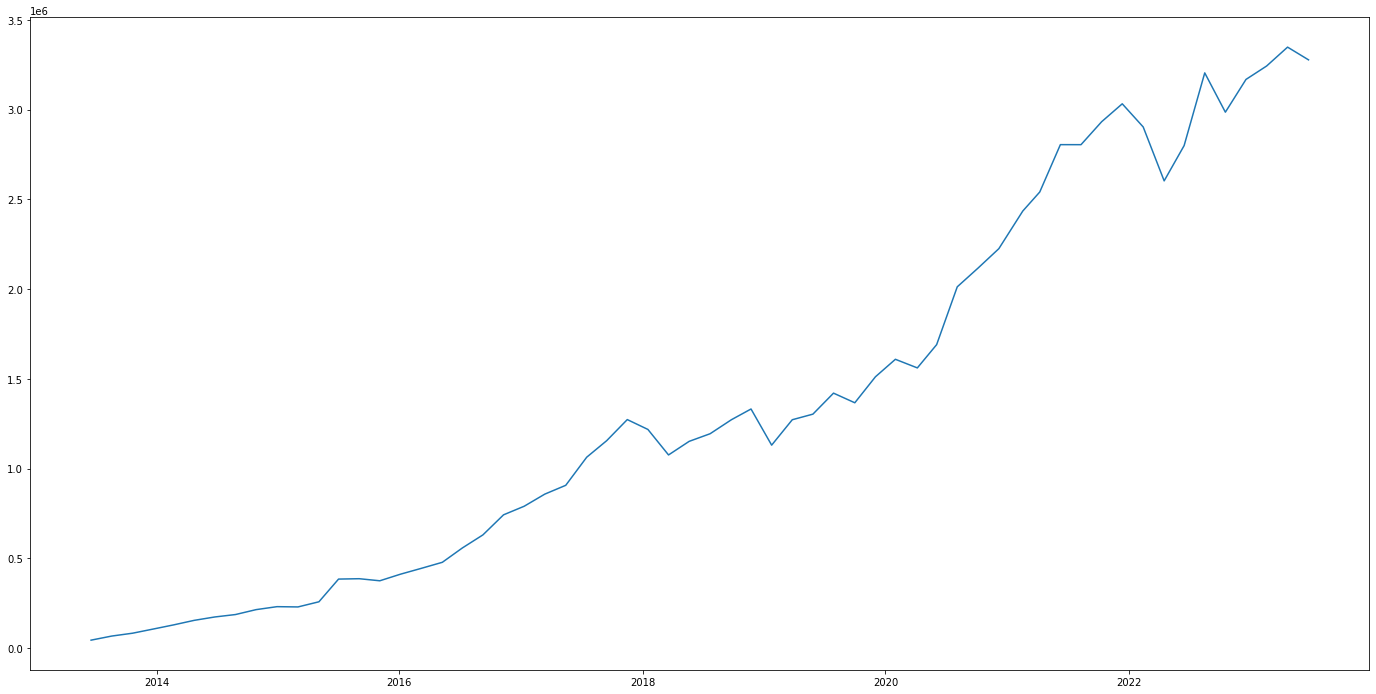

531.1027499270053


In [50]:

day_index = avg_profit_df4.index.values
initial_money2 = 600000
now_money2 = 600000
add_money2 = 0
now_profit2 = 0
all_profit2 = 0
all_profit_list2 = []
all_asset2 = []
for i in range(60):
    now_profit2 = now_money2*(profit_percentage[i]-1)
    all_profit2 += now_profit2
    all_profit_list2.append(all_profit2)
    now_money2 = now_profit2+now_money
    all_asset2.append(now_money2)
plt.figure(figsize=(24,12))
plt.plot(day_index[:60], all_asset[::-1])
plt.show()
print(all_asset2[-1]*100/initial_money2)

In [38]:
T1 = '''15.88825379
6.384016276
-6.028794898
4.323618772
2.528316756
4.174841152
-0.736913451
-3.787639245
3.979770829
-1.591626855
-9.368045439
3.809466042
41.45748132
-4.668956119
-8.181128201
4.447202122
3.110041658
3.06422579
12.51763058
9.533109206
14.5812825
3.744105558
6.032812332
3.396531623
15.07498992
6.780918531
8.457852515
-5.88843961
-13.31759233
5.180017568
1.958291806
4.863760162
3.130588131
-16.63715437
10.76521007
0.878052443
7.451640913
-5.189160358
9.13578888
5.131681568
-4.229745265
7.0286867
17.88547884
4.156841026
4.20290067
8.529889053
3.536582683
9.600065863
-0.718894677
3.843907372
2.727743023
-4.917967897
-11.03388386
6.783325299
13.76168486
-7.457021445
5.444272441
1.726879698
2.629183787
-2.714895916
-12.84132786
30.98610674
14.16994941
5.75408635
8.448787912
3.508315867
22.13022086
-3.546285593
11.28139946
-3.078710033
9.71107703
-3.737145839
0.447564696
-8.638122659
6.432541083
-13.06646202
6.270231692
15.78816377
8.542261507
9.245890195
-2.44426703'''.split('\n')
print(T1)
T5 = '''6.974640354
1.619578391
-5.903172853
8.331928173
5.318089313
0.962356174
-1.530152747
-1.673190697
-2.092548767
0.558994736
7.353499556
-2.132754908
-2.43743418
-2.132754908
0.341047724
0.46894062
3.361888517
-0.990061912
0.816996462
6.074802889
3.697395175
-0.871310774
6.012867798
-1.091767656
6.937610111
4.067645036
3.25022249
-3.915891821
-5.2422882
-0.542486138
0.222723174
0.997458679
-4.237750224
-9.492169541
-12.3398204
9.014920963
-0.297553469
-6.254271738
1.059197236
5.042878149
-1.568283925
1.573784522
15.86909199
4.049042395
-0.685893119
-1.32400142
-2.927891368
14.03726267
-2.894675937
3.696210273
-2.212069939
-3.381310879
-5.993728164
-0.354620524
3.695803716
-4.118175716
-0.093321766
-1.722957045
-1.014345362
5.779319862
-4.702982719
4.354544435
8.797025134
7.404762943
9.001974166
4.82145487
15.79377856
-2.567946891
8.120454941
-0.449198338
1.836307048
-0.136187324
2.993892508
-3.185920033
2.607266724
-4.030975292
0.17971514
8.251711433
4.165959302
12.44642632
3.115078105'''.split('\n')
print(T5)
T3 = '''11.38522434
5.415166705
-9.21940715
6.99663407
4.976466983
0.178606643
-2.157505993
-3.301531281
-2.627757581
-3.002210153
0.996577229
-2.660344955
12.90301452
1.42261808
-4.126530255
0.441141358
4.364419729
2.787074042
12.60027855
7.007050593
8.546605246
-0.351964565
10.51248104
2.435381363
19.00288061
3.169365812
5.996639476
-8.085434938
-13.69798274
6.516992369
-0.030147602
10.3276377
3.530503608
-15.72939258
4.47137337
3.335090449
5.623679226
-10.23586565
9.797390419
3.767190269
-6.513669588
10.74321072
24.70845161
1.570314522
3.860364093
8.648266201
3.714590082
8.724500677
-2.932493147
1.801493523
3.006950525
-10.55215757
-11.17879925
-0.164992449
16.73485272
-6.849856759
4.175010654
1.429547327
4.234407151
-0.045876213
-15.5277293
38.59444033
14.84295195
6.409873152
10.26283278
3.407475221
20.86002152
-5.913316038
11.14959837
-2.315473112
9.568499708
-5.076532544
-1.465425873
-6.974363363
6.290104585
-12.61447699
7.778650038
15.84766568
9.034020373
11.32574244
-1.555372418'''.split('\n')
# print(T3)
# print(len(T1),len(T3),len(T5))
import pandas as pd
import numpy as np

#(日期舊到新)
T7 = pd.read_excel(r'C:\Users\User\Desktop\code\python\stockdata_VCP\VCP_predict_project\ETF test\all template(S45789)(1Week)1M profit.xlsx')
T7.set_index('Unnamed: 0', inplace=True)
# display(T7)
T6 = T7.iloc[:-1, 10].values[::-1]
T5 = T7.iloc[:-1, 4].values[::-1]
T11 = T7.iloc[:-1, 16].values[::-1]
Tm = T7.iloc[:-1, 22].values[::-1]
display(T7)

['15.88825379', '6.384016276', '-6.028794898', '4.323618772', '2.528316756', '4.174841152', '-0.736913451', '-3.787639245', '3.979770829', '-1.591626855', '-9.368045439', '3.809466042', '41.45748132', '-4.668956119', '-8.181128201', '4.447202122', '3.110041658', '3.06422579', '12.51763058', '9.533109206', '14.5812825', '3.744105558', '6.032812332', '3.396531623', '15.07498992', '6.780918531', '8.457852515', '-5.88843961', '-13.31759233', '5.180017568', '1.958291806', '4.863760162', '3.130588131', '-16.63715437', '10.76521007', '0.878052443', '7.451640913', '-5.189160358', '9.13578888', '5.131681568', '-4.229745265', '7.0286867', '17.88547884', '4.156841026', '4.20290067', '8.529889053', '3.536582683', '9.600065863', '-0.718894677', '3.843907372', '2.727743023', '-4.917967897', '-11.03388386', '6.783325299', '13.76168486', '-7.457021445', '5.444272441', '1.726879698', '2.629183787', '-2.714895916', '-12.84132786', '30.98610674', '14.16994941', '5.75408635', '8.448787912', '3.508315867',

,T5 S4 profit,T5 S7 profit,T5 S5 profit,T5 S8 profit,T5 S9 profit,T5 numbers,T6 S4 profit,T6 S7 profit,T6 S5 profit,T6 S8 profit,...,T11 S8 profit,T11 S9 profit,T11 numbers,TM S4 profit,TM S7 profit,TM S5 profit,TM S8 profit,TM S9 profit,TM numbers,週期
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2009-11-25,2.716667,0.516667,0.516667,2.716667,-0.850000,6,7.994,6.248,6.768,8.514,...,10.917241,7.148276,29,8.088462,6.076923,6.861538,8.873077,6.736538,52,多
2009-12-02,12.966667,12.966667,14.466667,14.466667,15.900000,12,11.160,10.396,11.794,12.558,...,13.940476,18.761905,42,12.800000,12.921154,14.325000,14.203846,15.753846,52,多
2009-12-09,5.115385,5.576923,6.500000,6.038462,6.538462,13,1.944,2.162,2.572,2.354,...,4.897778,9.624444,45,7.190741,6.800000,7.272222,7.662963,7.770370,54,多
2009-12-16,2.609091,3.700000,4.245455,3.154545,3.363636,11,4.096,3.746,4.106,4.456,...,3.621053,1.663158,38,6.894828,6.837931,7.562069,7.618966,6.591379,58,多
2009-12-23,-0.725000,0.275000,-1.250000,-2.250000,1.387500,8,1.328,1.480,1.974,1.942,...,3.290909,4.750000,22,2.550000,2.310000,2.722000,3.082000,2.998000,50,多
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,6.616216,6.721622,7.867568,7.762162,10.391892,37,8.328,7.612,9.188,10.024,...,4.708511,4.329787,47,3.750515,3.708935,4.137801,4.200000,4.024399,291,多
2023-06-08,0.838298,0.940426,1.221277,1.119149,0.597872,47,2.894,3.208,3.794,3.480,...,-2.335088,-1.533333,57,1.456229,1.399327,1.574074,1.684848,2.103704,297,多
2023-06-15,4.190476,3.695238,4.409524,4.904762,4.314286,42,3.126,3.160,3.924,3.890,...,5.178846,5.430769,52,2.056897,2.059310,2.706897,2.704483,3.561724,290,多


In [34]:
import pandas as pd


# 讀取Excel文件
file_path = r'C:\Users\User\Desktop\code\python\stockdata_VCP\VCP_predict_project\history_data\2330.TW.csv'
df = pd.read_csv(file_path)
df0050close = df['Adj Close']
profit0050_list = []
profit0050 = 0
for i in range(81):
    n = -(i*42)-28
    profit0050 = df0050close.iloc[n]/df0050close.iloc[n-42]-1
    profit0050_list.append(profit0050)
profit0050_list = profit0050_list[::-1]
print(profit0050_list)
print("比較的平均收益", np.mean(profit0050_list))

[0.08040201439439199, -0.07286820806972416, 0.023411458267270646, 0.02387819520539436, -0.0016775821193480978, 0.07563022605001501, 0.10937476612184582, -0.035211419721950854, 0.09927038373290964, -0.03442087419116657, -0.008608034982973689, 0.09985511955680426, 0.013157880417783874, 0.10909096969929855, -0.05620614577285821, -0.044111793846072334, 0.15746957098786263, 0.04651165096304033, 0.1277776587650612, -0.009852066646314883, 0.08955203763944386, -0.037685722832121016, 0.0048782236580862115, 0.014562963999823486, -0.004784681155493908, 0.14903862775943422, 0.046024932617723335, -0.014337715454729949, 0.016597318188706467, 0.12653066089281362, 0.03623211447102581, 0.0, -0.006993135908488601, -0.08445804867744733, 0.09523805642294358, 0.039855131520793785, 0.03135888150766375, 0.05743238050759891, 0.055816474338218125, 0.11320753327032618, 0.07062161508789067, -0.05013176136805342, 0.038888558479058144, 0.09893072128329283, 0.0660177877173358, 0.02358471613630342, 0.110599122021627

In [39]:
import numpy as np

T1_n = np.array(T1).astype(float)
T3_n = np.array(T3).astype(float)
T5_n = np.array(T5).astype(float)
T6_n = np.array(T6).astype(float)
T11_n = np.array(T11).astype(float)
Tm_n = np.array(Tm).astype(float)
T1_n = T1_n/100
T6_n = T6_n/100
T5_n = T5_n/100
T11_n = T11_n/100
Tm_n = Tm_n/100
# 將第三組ETF績效數據轉換成numpy數組
returns3 = T11_n

# 年化收益率
annual_returns3 = (np.prod(returns3 + 1) ** (6 / len(returns3))) - 1

# 標準差
std_dev3 = np.std(returns3, ddof=1)

# 夏普比率
risk_free_rate = 0.02/12  # 假設無風險利率為2%
sharpe_ratio3 = (annual_returns3 - risk_free_rate) / std_dev3

# 計算市場指數數據（假設市場指數收益率）
market_returns3 = profit0050_list

# Beta值
# beta3 = np.cov(returns3, market_returns3, ddof=1)[0, 1] / np.var(market_returns3, ddof=1)

# # Alpha值
# alpha3 = annual_returns3 - (beta3 * (np.mean(market_returns3) - risk_free_rate))

print("第1組ETF的年化收益率：", annual_returns3)
print("第1組ETF的標準差：", std_dev3)
print("第1組ETF的夏普比率：", sharpe_ratio3)
print("第1組ETF的SD：", std_dev3)
# print("第1組ETF的Beta值：", beta3)
# print("第1組ETF的Alpha值：", alpha3)


第1組ETF的年化收益率： 0.11224329713160586
第1組ETF的標準差： 0.043248491179549056
第1組ETF的夏普比率： 2.556774293139448
第1組ETF的SD： 0.043248491179549056


In [40]:
returns3 = Tm_n

# 年化收益率
annual_returns3 = (np.prod(returns3 + 1) ** (6 / len(returns3))) - 1

# 標準差
std_dev3 = np.std(returns3, ddof=1)

# 夏普比率
risk_free_rate = 0.02/12  # 假設無風險利率為2%
sharpe_ratio3 = (annual_returns3 - risk_free_rate) / std_dev3

# 計算市場指數數據（假設市場指數收益率）
market_returns3 = profit0050_list

# Beta值
# beta3 = np.cov(returns3, market_returns3, ddof=1)[0, 1] / np.var(market_returns3, ddof=1)

# # Alpha值
# alpha3 = annual_returns3 - (beta3 * (np.mean(market_returns3) - risk_free_rate))

print("第1組ETF的年化收益率：", annual_returns3)
print("第1組ETF的標準差：", std_dev3)
print("第1組ETF的夏普比率：", sharpe_ratio3)
print("第1組ETF的SD：", std_dev3)
# print("第1組ETF的Beta值：", beta3)
# print("第1組ETF的Alpha值：", alpha3)

第1組ETF的年化收益率： 0.1476384642056594
第1組ETF的標準差： 0.04551804519333489
第1組ETF的夏普比率： 3.2068995256493804
第1組ETF的SD： 0.04551804519333489


In [36]:
returns3 = T5_n

# 年化收益率
annual_returns3 = (np.prod(returns3 + 1) ** (6 / len(returns3))) - 1

# 標準差
std_dev3 = np.std(returns3, ddof=1)

# 夏普比率
risk_free_rate = 0.02/12  # 假設無風險利率為2%
sharpe_ratio3 = (annual_returns3 - risk_free_rate) / std_dev3

# 計算市場指數數據（假設市場指數收益率）
market_returns3 = profit0050_list

# Beta值
# beta3 = np.cov(returns3, market_returns3, ddof=1)[0, 1] / np.var(market_returns3, ddof=1)

# # Alpha值
# alpha3 = annual_returns3 - (beta3 * (np.mean(market_returns3) - risk_free_rate))

print("第1組ETF的年化收益率：", annual_returns3)
print("第1組ETF的標準差：", std_dev3)
print("第1組ETF的夏普比率：", sharpe_ratio3)
print("第1組ETF的SD：", std_dev3)
# print("第1組ETF的Beta值：", beta3)
# print("第1組ETF的Alpha值：", alpha3)

第1組ETF的年化收益率： 0.1287414295323277
第1組ETF的標準差： 0.07462732511841572
第1組ETF的夏普比率： 1.702791339017227
第1組ETF的SD： 0.07462732511841572


In [37]:
returns3 = T6_n

# 年化收益率
annual_returns3 = (np.prod(returns3 + 1) ** (6 / len(returns3))) - 1

# 標準差
std_dev3 = np.std(returns3, ddof=1)

# 夏普比率
risk_free_rate = 0.02/12  # 假設無風險利率為2%
sharpe_ratio3 = (annual_returns3 - risk_free_rate) / std_dev3

# 計算市場指數數據（假設市場指數收益率）
market_returns3 = profit0050_list

# Beta值
# beta3 = np.cov(returns3, market_returns3, ddof=1)[0, 1] / np.var(market_returns3, ddof=1)

# # Alpha值
# alpha3 = annual_returns3 - (beta3 * (np.mean(market_returns3) - risk_free_rate))

print("第1組ETF的年化收益率：", annual_returns3)
print("第1組ETF的標準差：", std_dev3)
print("第1組ETF的夏普比率：", sharpe_ratio3)
print("第1組ETF的SD：", std_dev3)
# print("第1組ETF的Beta值：", beta3)
# print("第1組ETF的Alpha值：", alpha3)

第1組ETF的年化收益率： 0.12081957726634807
第1組ETF的標準差： 0.04493761281124295
第1組ETF的夏普比率： 2.6515184751841225
第1組ETF的SD： 0.04493761281124295
